# W207 Group Project - What's Cooking?

Group members: Daniel Volk, Aaron Yuen

Kaggle competition link: https://www.kaggle.com/c/whats-cooking

## Business Understanding

#### Description from Kaggle:

Picture yourself strolling through your local, open-air market... What do you see? What do you smell? What will you make for dinner tonight?

If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see.

Some of our strongest geographic and cultural associations are tied to a region's local foods. This playground competitions asks you to predict the category of a dish's cuisine given a list of its ingredients. 

#### What problem are we trying to solve?

The problem at hand is to categorize the cuisine of a recipe based on the provided list of ingredients. This competition was hosted by Yummly, a company that builds a mobile app and website that provides recipe recommendations personalized to the individual's tastes. This is a multi-class classification problem where the input is a list of strings (ingredients) and the output we are trying to predict is one of the various classes of cuisine. 

#### What are the relevant metrics?

In this classification problem, there are a few relevant metrics we will explore:
1. Accuracy
2. Precision
3. Recall

#### How do we plan to improve these metrics?

We will start by establishing a baseline using a very simple classifier with little parameter tuning and feature engineering.  Once we have established a baseline, we will then build upon it with trying various models, tuning various hyper-parameters, and spend considerable effects in feature engineering. We will also iterate through error analysis, which will also be shared in this deliverable as well.

MORE HERE ON SPECIFIC TECHNIQUES WE WILL TRY

#### What will we deliver?

The main deliverable is this iPython notebook that completes the full end-to-end project from problem scope, data understanding, exploratory analysis, baseline model, feature engineering, error analysis and final results.

## Data Understanding

#### Library Imports

In [138]:
# Loading all relevant libraries
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import seaborn as sn

matplotlib.rc('font', **{'weight' : 'bold', 'size':10} )

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score
import string
from nltk.stem import WordNetLemmatizer



#### Data Loading

The provided sources of data from the competition are:

1. train.json - Includes both the list of ingredients as features and the cuisine as the class
2. test.json - Includes only the list of ingredients as features. The cuisine (e.g. the class) is not present.


In [40]:
# Read train and test dataset from the provided JSONs
train = pd.read_json("data/train.json")
test = pd.read_json("data/test.json")

# Separate to raw features dataframe
X_train_all = train["ingredients"]
X_test = test["ingredients"]

# Separate label dataframe
y_train_all = train["cuisine"]

In [41]:
print X_train_all.shape
print y_train_all.shape

(39774,)
(39774,)


#### Example features and labels

In [42]:
print "First 10 example features from the training set"
print X_train_all.head(10)
print ""

print "First 10 example labels from the training set"
print y_train_all.head(10)
print ""

print "First 10 example features from the test set"
print X_test.head(10)
print ""

First 10 example features from the training set
0    [romaine lettuce, black olives, grape tomatoes...
1    [plain flour, ground pepper, salt, tomatoes, g...
2    [eggs, pepper, salt, mayonaise, cooking oil, g...
3                  [water, vegetable oil, wheat, salt]
4    [black pepper, shallots, cornflour, cayenne pe...
5    [plain flour, sugar, butter, eggs, fresh ginge...
6    [olive oil, salt, medium shrimp, pepper, garli...
7    [sugar, pistachio nuts, white almond bark, flo...
8    [olive oil, purple onion, fresh pineapple, por...
9    [chopped tomatoes, fresh basil, garlic, extra-...
Name: ingredients, dtype: object

First 10 example labels from the training set
0          greek
1    southern_us
2       filipino
3         indian
4         indian
5       jamaican
6        spanish
7        italian
8        mexican
9        italian
Name: cuisine, dtype: object

First 10 example features from the test set
0    [baking powder, eggs, all-purpose flour, raisi...
1    [sugar, egg yolks,

In [43]:
# Check for nulls in the ingredients column
(X_train_all.isnull()).sum()

0

#### Distribution of training classes

Here we can see that there is a high imbalance of classes, with majority of the cuisine to be Italian, Mexican, and Southern US. We'll need to ensure in the data preparation step that these are more balanced before training.

Text(0.5,0,u'Number of examples')

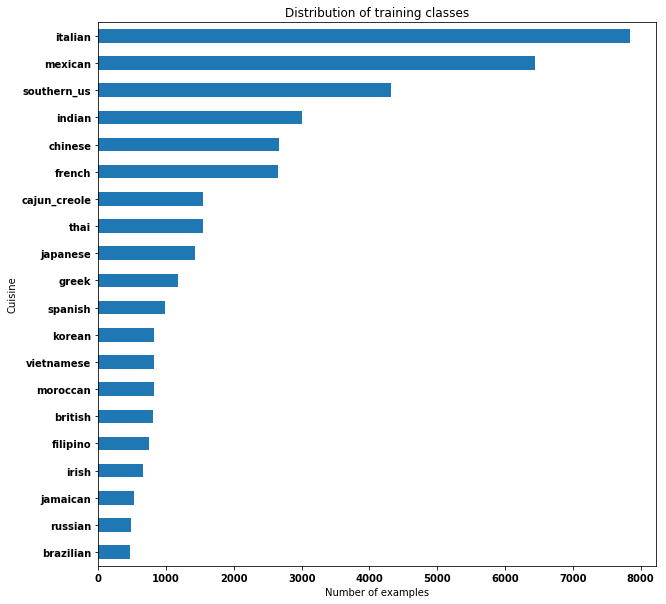

In [44]:
# Plot distribution of training classes
plt.figure(figsize=(10,10))
f = y_values = y_train_all.value_counts().plot(kind='barh')
f.invert_yaxis()
plt.title("Distribution of training classes")
plt.ylabel("Cuisine")
plt.xlabel("Number of examples")

#### Number of Ingredients per Recipe

Text(0.5,0,u'Ingredients per recipe')

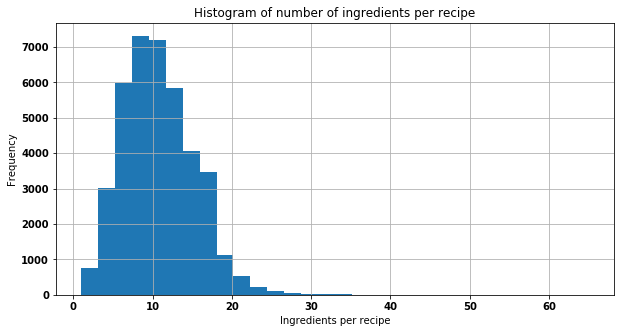

In [45]:
plt.figure(figsize=(10,5))
f = X_train_all.apply(len).hist(bins=30)
plt.title("Histogram of number of ingredients per recipe")
plt.ylabel("Frequency")
plt.xlabel("Ingredients per recipe")

#### Top Ingredients - Across All Cuisines

The top ingredients seem to be very common ingredients like salt, sugar, oil, etc. which may not be cusine-specific. These features could potentially be ruled out (or let the model feature-select). Here we can also see that there are similar ingredients that should be deduplicated (e.g. kosher salt and salt, olive oil and oil). 

In [46]:
# For each row, go through each ingredient and create a cuisine-ingredient pair
ing_cuisine_pair = []
for i in xrange(X_train_all.shape[0]):
    for ingredient in X_train_all[i]:
        ing_cuisine_pair.append([y_train_all[i], ingredient])

ing_cuisine = pandas.DataFrame(ing_cuisine_pair, columns=['cuisine', 'ingredient'])

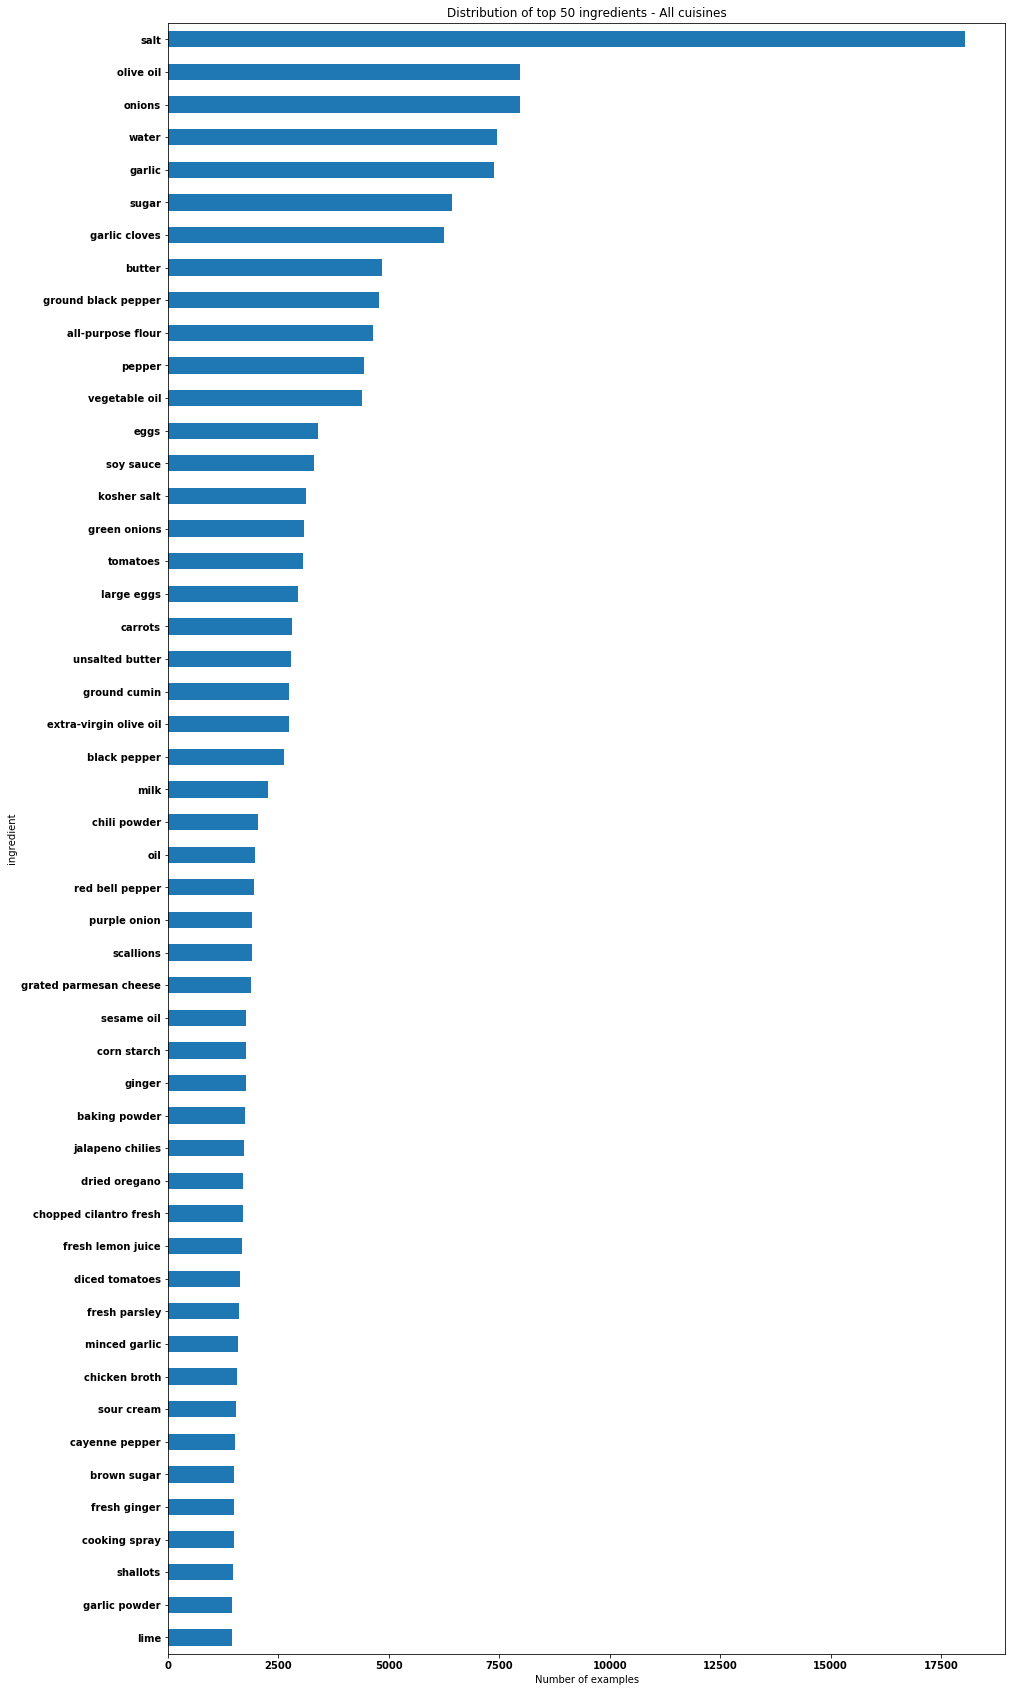

In [47]:
plt.figure(figsize=(15,30))
plt.title("Distribution of top 50 ingredients - All cuisines")
plt.ylabel("ingredient")
plt.xlabel("Number of examples")
f = ing_cuisine['ingredient'].value_counts()[:50].plot(kind='barh')
f.invert_yaxis()

#### Top Ingredients - By Cuisine

Similarly, here by cuisine the top ingredients are common ingredients like salt, but we start to see some cuisine-specific incredients like jalapeno chilies for Mexican and soy sauce for Chinese.

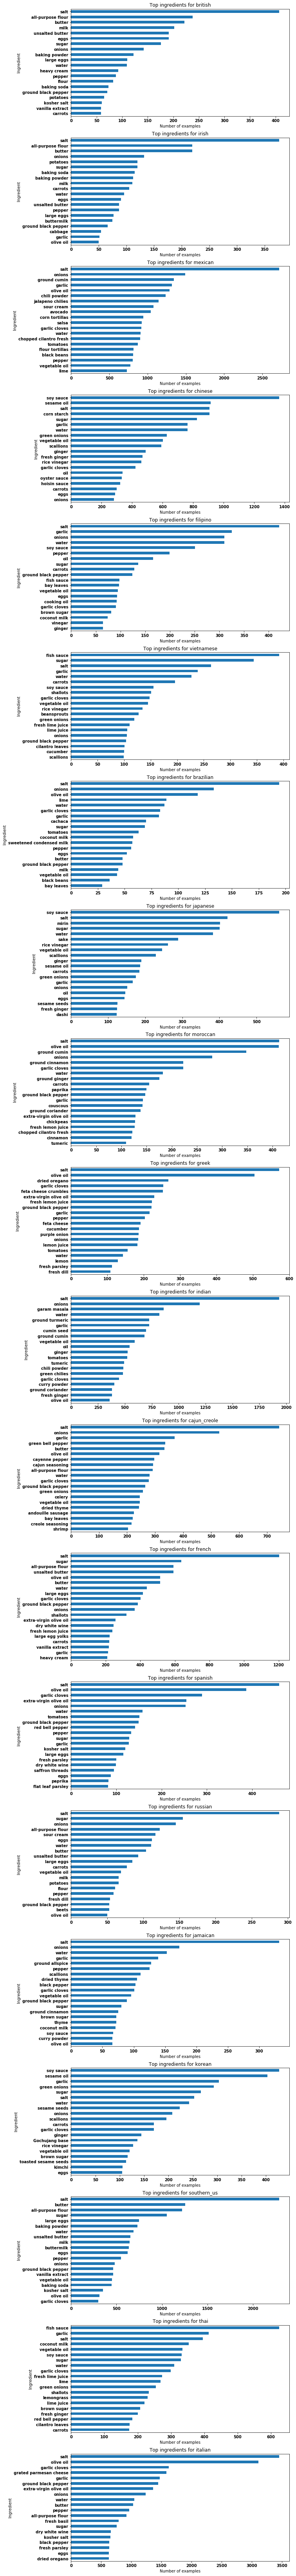

In [48]:
# Top ingredients by cuisine
plt.figure(figsize=(10,120))

grouped = ing_cuisine.groupby('cuisine')

cuisines = grouped.groups.keys()
for i in range(len(cuisines)):
    plt.subplot(20, 1, i+1)
    
    f = ing_cuisine[ing_cuisine['cuisine'] == cuisines[i]]['ingredient'].value_counts()[:20].plot(kind='barh')
    f.invert_yaxis()
    plt.title("Top ingredients for %s" % cuisines[i])
    plt.ylabel("Ingredient")
    plt.xlabel("Number of examples")
    i+=1

plt.show()

#### Unique ingredients

In [49]:
d = pandas.DataFrame(ing_cuisine['ingredient'].value_counts())
print d

                                                    ingredient
salt                                                     18049
olive oil                                                 7972
onions                                                    7972
water                                                     7457
garlic                                                    7380
sugar                                                     6434
garlic cloves                                             6237
butter                                                    4848
ground black pepper                                       4785
all-purpose flour                                         4632
pepper                                                    4438
vegetable oil                                             4385
eggs                                                      3388
soy sauce                                                 3296
kosher salt                                            

## Baseline Data Preparation

In [50]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train_all, y_train_all, random_state=2)

In [51]:
print "The shape of X_train is", X_train.shape
print "The shape of X_dev is ", X_dev.shape
print "The shape of y_train is", y_train.shape
print "The shape of y_dev is", y_dev.shape

The shape of X_train is (29830,)
The shape of X_dev is  (9944,)
The shape of y_train is (29830,)
The shape of y_dev is (9944,)


In [52]:
def list_to_string(l):
    return '|'.join(l).replace(' ', '_').replace('|', ' ')

X_train_str = X_train.apply(list_to_string)
X_dev_str = X_dev.apply(list_to_string)

## Baseline Model

#### Training

For the baseline model, we are starting with a very simple logistic regression model with no hyperparameter tuning. We will also be using a very basic count vectorizer. The goal of this is really to establish a baseline and understand what the metrics are for this very basic model.

In [144]:
base_pipeline = Pipeline(steps=[
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
base_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

#### Evaluation - Accuracy

Note that accuracy is NOT a good measure here especially given that there is high class imbalance. This is only calculated to establish a baseline.

In [145]:
print "Accuracy of the base model is", base_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.776448109413


#### Evaluation - Precision & Recall

Precision and recall are better measures to use here with high class imbalance.

In [55]:
y_pred = base_pipeline.predict(X_dev_str)
print "Precision of the base model is", precision_score(y_dev, y_pred, average='macro') 
print "Recall of the base model is", recall_score(y_dev, y_pred, average='macro') 

Precision of the base model is 0.752390197859
Recall of the base model is 0.658163192353


#### Confusion matrix

In [108]:
pandas.DataFrame(confusion_matrix(y_dev, y_pred), index=base_pipeline.classes_, columns=base_pipeline.classes_)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,62,0,2,0,2,4,0,4,0,7,6,0,0,17,0,1,9,3,4,0
british,2,65,1,1,0,37,1,7,9,16,0,1,1,3,0,4,56,2,0,0
cajun_creole,1,3,267,1,0,10,1,1,0,25,0,0,1,8,0,1,56,1,0,0
chinese,0,0,2,556,11,4,0,7,0,9,1,19,12,7,1,2,9,0,18,12
filipino,4,0,0,17,113,4,0,2,2,8,1,0,1,8,0,1,16,1,6,6
french,0,4,5,1,2,408,9,3,8,118,0,1,0,6,4,4,52,11,0,0
greek,0,0,0,0,0,7,172,4,0,57,0,1,0,1,4,1,5,6,0,0
indian,1,0,1,3,2,5,4,666,0,15,0,10,0,19,15,0,4,0,13,0
irish,0,15,0,1,0,21,1,2,70,21,0,0,0,2,0,2,38,1,1,0
italian,0,6,5,1,1,82,18,7,2,1764,0,0,0,19,6,0,45,6,1,0


#### Error Analysis

In [57]:
print "MORE HERE"

MORE HERE


## Baseline Model with Broadmatch

In [81]:
def format_ingredient(s):
    lm = WordNetLemmatizer()
    printable = string.printable
    PERMITTED_CHARS = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ " 

    filter(lambda x: x in printable, s)
    s = "".join(c for c in s if c in PERMITTED_CHARS)
    s = lm.lemmatize(s.lower())

    return s 

In [84]:
bm_map = pd.read_csv("analysis/broadmatched_ingredients.csv")
bm_dict = {}
for i, row in bm_map.iterrows():
    bm_dict[row['Original Ingredient']] = row['Broadmatched Ingredient']

In [130]:
def broadmatch_string(s):
    return ' '.join(bm_dict[format_ingredient(w.replace('_', ' '))].replace(' ', '_') for w in s.split(' '))

def broadmatch_X(X):
    return X.apply(broadmatch_string)

In [146]:
broadmatch_pipeline = Pipeline(steps=[
    ('broaddmatch', FunctionTransformer(broadmatch_X, validate=False)),
    ('countvectorizer', CountVectorizer(binary=True)),
    ('lr', LogisticRegression()),
])
broadmatch_pipeline.fit(X_train_str, y_train)

Pipeline(memory=None,
     steps=[('broaddmatch', FunctionTransformer(accept_sparse=False,
          func=<function broadmatch_X at 0x1a30f545f0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=True, dec...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [147]:
print "Accuracy of the base model is", broadmatch_pipeline.score(X_dev_str, y_dev)

Accuracy of the base model is 0.75522928399


## Final Data Modeling

TBD

## Evaluation

TBD

## Deployment

Deployment is out of scope of this project, since there is no deployment in the deliverable other than this notebook.